In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2398778 sha256=fda01e9a53ba4f13f9a026c70b8588668a216d19e56ac06d25963fac4633b1f8
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Episode   1 | reward   -13.9 | steps   500/200000 | critic loss    nan | actor loss    nan | buffer    500 |   0.2%
Episode   2 | reward   -13.0 | steps  1000/200000 | critic loss    nan | actor loss    nan | buffer   1000 |   0.5%
Episode   3 | reward   -11.4 | steps  1500/200000 | critic loss    nan | actor loss    nan | buffer   1500 |   0.8%
Episode   4 | reward   -15.2 | steps  2000/200000 | critic loss    nan | actor loss    nan | buffer   2000 |   1.0%
Episode   5 | reward   -16.1 | steps  2500/200000 | critic loss    nan | actor loss    nan | buffer   2500 |   1.2%
Episode   6 | reward   -15.2 | steps  3000/200000 | critic loss    nan | actor loss    nan | buffer   3000 |   1.5%
Episode   7 | reward   -19.9 | steps  3500/200000 | critic loss    nan | actor loss    nan | buffer   3500 |   1.8%
Episode   8 | reward   -20.0 | steps  4000/200000 | critic loss    nan | actor loss    nan | buffer   4000 |   2.0%
Episode   9 | reward    -6.2 | steps  4500/200000 | critic loss    nan |

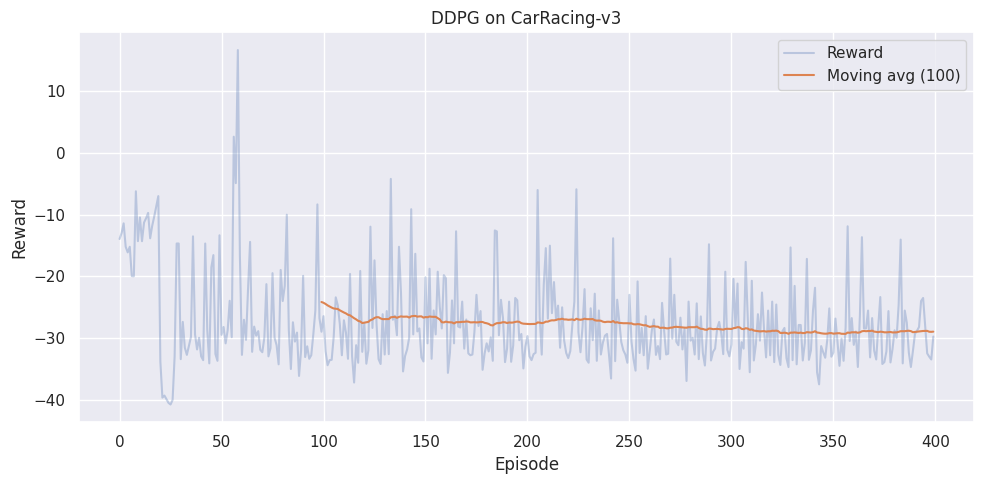

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
import os
import time
import gc
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns
sns.set_theme()

from gymnasium.wrappers import (
    GrayscaleObservation,
    ResizeObservation,
    FrameStackObservation,
)

# CONFIG

ENV_NAME = "CarRacing-v3"
SEED = 42

TOTAL_STEPS = 200_000
START_STEPS = 10_000
TRAIN_EVERY = 8
MAX_EPISODE_STEPS = 500

BATCH_SIZE = 128
BUFFER_SIZE = 25_000

GAMMA = 0.99
TAU = 0.005

LR_ACTOR = 1e-4
LR_CRITIC = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_DIR = "/content/drive/MyDrive/car_racing_v3_ddpg"
os.makedirs(SAVE_DIR, exist_ok=True)

# SEED

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


# ENV

def make_env():
    env = gym.make(ENV_NAME, continuous=True)
    env.reset(seed=SEED)
    env = GrayscaleObservation(env)
    env = ResizeObservation(env, (84, 84))
    env = FrameStackObservation(env, stack_size=4)
    return env


# NETWORKS

class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 4, 84, 84)  # batch, channels, height, width
            n_flat = self.cnn(dummy).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(n_flat, 512),
            nn.ReLU(),
            nn.Linear(512, 3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.fc(self.cnn(x))


class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 4, 84, 84)  # batch, channels, height, width
            n_flat = self.cnn(dummy).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(n_flat + 3, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x, a):
        x = self.cnn(x)
        x = torch.cat([x, a], dim=1)
        return self.fc(x)


# REPLAY BUFFER

class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def push(self, s, a, r, s_, d):
        self.buffer.append((s, a, r, s_, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_, d = map(np.array, zip(*batch))
        return s, a, r, s_, d

    def __len__(self):
        return len(self.buffer)


# OU NOISE

class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.4):
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.reset()

    def reset(self):
        self.state = np.ones(self.size) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state)
        dx += self.sigma * np.random.randn(self.size)
        self.state += dx
        return self.state


# INIT

env = make_env()
actor = Actor().to(DEVICE)
critic = Critic().to(DEVICE)
actor_target = Actor().to(DEVICE)
critic_target = Critic().to(DEVICE)

actor_target.load_state_dict(actor.state_dict())
critic_target.load_state_dict(critic.state_dict())

for p in actor_target.parameters():
    p.requires_grad = False
for p in critic_target.parameters():
    p.requires_grad = False

opt_actor = optim.AdamW(actor.parameters(), lr=LR_ACTOR)
opt_critic = optim.AdamW(critic.parameters(), lr=LR_CRITIC)

buffer = ReplayBuffer(BUFFER_SIZE)
action_dim = env.action_space.shape[0]
ou_noise = OUNoise(action_dim)


# ACTION

def select_action(state):
    state = torch.tensor(state[None], dtype=torch.float32, device=DEVICE) / 255.0

    with torch.no_grad():
        action = actor(state).cpu().numpy()[0]

    action += ou_noise.sample()

    steer = np.clip(action[0], -1.0, 1.0)
    gas = np.clip((action[1] + 1) / 2, 0.0, 1.0)
    brake = np.clip((action[2] + 1) / 2, 0.0, 1.0)

    return np.array([steer, gas, brake], dtype=np.float32)


# TRAIN STEP

def train_step():
    states, actions, rewards, next_states, dones = buffer.sample(BATCH_SIZE)

    states = torch.tensor(states, dtype=torch.float32, device=DEVICE) / 255.0
    next_states = torch.tensor(next_states, dtype=torch.float32, device=DEVICE) / 255.0
    actions = torch.tensor(actions, dtype=torch.float32, device=DEVICE)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=DEVICE).unsqueeze(1)
    dones = torch.tensor(dones, dtype=torch.float32, device=DEVICE).unsqueeze(1)

    with torch.no_grad():
        next_actions = actor_target(next_states)
        q_target = rewards + GAMMA * (1 - dones) * critic_target(next_states, next_actions)

    q_current = critic(states, actions)
    critic_loss = F.mse_loss(q_current, q_target)

    opt_critic.zero_grad()
    critic_loss.backward()
    opt_critic.step()

    actor_loss = -critic(states, actor(states)).mean()

    opt_actor.zero_grad()
    actor_loss.backward()
    opt_actor.step()

    for target_param, param in zip(actor_target.parameters(), actor.parameters()):
        target_param.data.mul_(1 - TAU).add_(TAU * param.data)

    for target_param, param in zip(critic_target.parameters(), critic.parameters()):
        target_param.data.mul_(1 - TAU).add_(TAU * param.data)

    return actor_loss.item(), critic_loss.item()


# TRAIN

state, _ = env.reset()

rewards_all = []
episode_reward = 0
episode_steps = 0
episode = 1

last_actor_loss = float("nan")
last_critic_loss = float("nan")

episode_start_time = time.time()
start_time = time.time()

for step in range(1, TOTAL_STEPS + 1):

    if step < START_STEPS:
        action = env.action_space.sample()
    else:
        action = select_action(state)

    next_state, reward, terminated, truncated, _ = env.step(action)

    done = terminated or truncated

    buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward
    episode_steps += 1

    if step >= START_STEPS and step % TRAIN_EVERY == 0:
        last_actor_loss, last_critic_loss = train_step()

    if done or episode_steps >= MAX_EPISODE_STEPS:
        fps = episode_steps / (time.time() - episode_start_time)
        progress = 100 * step / TOTAL_STEPS

        print(
            f"Episode {episode:3d} | "
            f"reward {episode_reward:7.1f} | "
            f"steps {step:5d}/{TOTAL_STEPS} | "
            f"critic loss {last_critic_loss:6.3f} | "
            f"actor loss {last_actor_loss:6.3f} | "
            f"buffer {len(buffer):6d} | "
            f"{progress:5.1f}%"
        )

        state, _ = env.reset()
        ou_noise.reset()

        rewards_all.append(episode_reward)
        episode_reward = 0
        episode_steps = 0
        episode += 1
        episode_start_time = time.time()

    if step % 50_000 == 0:
        torch.save(actor.state_dict(), f"{SAVE_DIR}/actor_{step}.pt")
        torch.save(critic.state_dict(), f"{SAVE_DIR}/critic_{step}.pt")
        gc.collect()
        torch.cuda.empty_cache()

env.close()

print("=" * 60)
print(f"Training finished")
print(f"Total steps: {TOTAL_STEPS}")
print(f"Total episodes: {episode - 1}")
print(f"Total time: {(time.time() - start_time)/60:.1f} min")
print("=" * 60)


# PLOT

rewards = np.array(rewards_all)
window = 100

plt.figure(figsize=(10, 5))
plt.plot(rewards, alpha=0.3, label="Reward")

if len(rewards) >= window:
    ma = np.convolve(rewards, np.ones(window) / window, mode="valid")
    plt.plot(np.arange(window - 1, len(rewards)), ma, label="Moving avg (100)")

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DDPG on CarRacing-v3")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/rewards.png")
plt.show()

In [ ]:
# env = make_env(render_mode="rgb_array")
# state, _ = env.reset()

# frames = []
# done = False
# actor.eval()

# while not done:
#     img = env.render()
#     frames.append(Image.fromarray(img))

#     state_t = torch.tensor(
#         np.expand_dims(state, 0),
#         dtype=torch.float32,
#         device=DEVICE
#     ) / 255.0

#     with torch.no_grad():
#         action = actor(state_t).cpu().numpy()[0]

#     action = np.array(
#         [action[0], (action[1] + 1) / 2, (action[2] + 1) / 2],
#         dtype=np.float32
#     )

#     state, _, terminated, truncated, _ = env.step(action)
#     done = terminated or truncated

# env.close()

# frames[0].save(
#     f"{SAVE_DIR}/carracing_episode.gif",
#     save_all=True,
#     append_images=frames[1:],
#     duration=40,
#     loop=0
# )

# print("GIF saved")

GIF saved
